# PROJECT 3: Webscraping, APIs, and NLP

### Problem Statement: What Factors Influence a Model's Ability to Make Accurate Predictions? 

### Imports 

In [900]:
import pandas as pd
import numpy as np
import requests
import time
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re


from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

pd.options.display.max_colwidth = 400

### READING IN SUBREDDIT DATA

In [901]:
df = pd.read_csv('data/subreddits.csv')

In [902]:
# Creating dataframe with columns needed 
df = df[['subreddit','title', 'selftext']]

In [903]:
df.head(25)

,subreddit,title,selftext
0,Jokes,What’s the difference between a potato fresh out of the oven and a pig thrown off a balcony?,One is a heated yam and the other is a yeeted ham.
1,Jokes,What state has the rudest IT people?,TechSAS
2,Jokes," The first ever  Gaming and  NFT $Elite Forces to host a $50,000 Warzone Tournament! Join now before it is too late! Whitelist for presale available! ",[removed]
3,Jokes,What's the worst part about Ad Blockers?,"Suddenly, there's no more hot moms in my area who want to meet up anymore"
4,Jokes,"Got this from a coworker. If you’re in a locked room with noting but a saw and a table, how do you escape?","Take the saw, cut the table in half, 2 halves make a whole, now you got a “whole” so you crawl through it and escape."
5,Jokes,My wife said she wanted 12 inches and make it hurt...,I stuck a metal ruler in there twice and it still wasnt enough...
6,Jokes,Why is it generally a bad idea to marry chess pieces?,Well many would think of it as a Rook-ie mistake
7,Jokes,Mathematics of marriage 😅,[removed]
8,Jokes,Optical Reaction,"""In my case,"" said the student to the sex researcher, ""when I get it part of the way in, my vision blurs. And when it's all the way in, I can't see a thing."" ""Now, that's an most interesting optical reaction,"" said the researcher. ""It may well have anatomical as well as physiological basis. If you don't mind, young man, I'd like to have a look at it.""\n\nSo, the student shrugged and stuck out ..."
9,Jokes," The first ever  Gaming and  NFT $Elite Forces to host a $50,000 Warzone Tournament! Join now before it is too late! Whitelist for presale available! ",[removed]


### DATA EVALUATION AND CLEANING 

In [904]:
df['subreddit'].value_counts()

relationship_advice    1500
Jokes                  1500
Name: subreddit, dtype: int64

In [905]:
# duplicated rows dropped to have all unqiue submissions 
df.drop_duplicates(inplace=True)

In [906]:
df.dtypes

subreddit    object
title        object
selftext     object
dtype: object

In [907]:
# Sum of amount of posts that were removed. They will not be useful. 
rem = sum(1 for i in df['selftext'] if i == '[removed]')

In [908]:
rem

366

In [909]:
rem2 = sum(1 for i in df['selftext'] if i == '[deleted]')

In [910]:
rem2

5

In [911]:
del_df = df[df.selftext != '[deleted]']

In [912]:
# Creating a new dataframe without the removed or deleted submissions. 
new_df = del_df[del_df.selftext != '[removed]'].copy()

In [913]:
new_df.shape

(2415, 3)

In [914]:
df.isnull().sum()

subreddit    0
title        0
selftext     4
dtype: int64

In [915]:
new_df.dropna(inplace=True)

In [916]:
# There are still over 1000 posts for each subreddit. 
new_df['subreddit'].value_counts()

relationship_advice    1308
Jokes                  1103
Name: subreddit, dtype: int64

In [917]:
new_df.reset_index(drop=True, inplace=True)

In [918]:
new_df.shape

(2411, 3)

In [919]:
new_df['subreddit'] = new_df['subreddit'].map({'Jokes':0, 'relationship_advice':1})

In [920]:
new_df.head()

,subreddit,title,selftext
0,0,What’s the difference between a potato fresh out of the oven and a pig thrown off a balcony?,One is a heated yam and the other is a yeeted ham.
1,0,What state has the rudest IT people?,TechSAS
2,0,What's the worst part about Ad Blockers?,"Suddenly, there's no more hot moms in my area who want to meet up anymore"
3,0,"Got this from a coworker. If you’re in a locked room with noting but a saw and a table, how do you escape?","Take the saw, cut the table in half, 2 halves make a whole, now you got a “whole” so you crawl through it and escape."
4,0,My wife said she wanted 12 inches and make it hurt...,I stuck a metal ruler in there twice and it still wasnt enough...


#### Descriptive statistics on the length of title and selftext:

In [921]:
new_df['title'].str.len().describe()
# average length of title: 57

count    2411.000000
mean       57.748652
std        37.656526
min         2.000000
25%        33.000000
50%        50.000000
75%        74.000000
max       299.000000
Name: title, dtype: float64

In [922]:
new_df['selftext'].str.len().describe()
# average length of selftext: 962

count     2411.000000
mean       962.071754
std       1423.917568
min          2.000000
25%         52.500000
50%        486.000000
75%       1336.000000
max      18973.000000
Name: selftext, dtype: float64

#### Descriptive statistics on the word count for title and selftext:

In [923]:
new_df['title'].str.split().str.len().describe()
# average word count of title: 11

count    2411.000000
mean       11.118623
std         7.453816
min         1.000000
25%         6.000000
50%        10.000000
75%        14.000000
max        62.000000
Name: title, dtype: float64

In [924]:
new_df['selftext'].str.split().str.len().describe()
# average word count of selftext: 187

count    2411.000000
mean      187.209457
std       276.703691
min         1.000000
25%        10.000000
50%        95.000000
75%       258.000000
max      3558.000000
Name: selftext, dtype: float64

In [982]:
new_df['title_word_count'] = new_df['title'].str.split().str.len()

In [983]:
new_df['selftext_word_count'] = new_df['selftext'].str.split().str.len()

In [984]:
# Average word count of title and self text by subreddit. Where 0:Jokes and 1: relationship_advice. 
new_df.groupby('subreddit').mean().round()[['title_word_count','selftext_word_count']]

,title_word_count,selftext_word_count
subreddit,,
0,10.0,37.0
1,12.0,314.0


The word count for relationship_advice self text is more than 8 times greater, on average, than the jokes self text. 

In [987]:
new_df.head(1)

,subreddit,title,selftext,tokenized_selftext,tokenized_title,lemmatized_tokenized_selftext,lemmatized_tokenized_title,stemmatized_tokenized_selftext,stemmatized_tokenized_title,title_str_length,selftext_str_length,title_word_count,selftext_word_count
0,0,What’s the difference between a potato fresh out of the oven and a pig thrown off a balcony?,One is a heated yam and the other is a yeeted ham.,"[one, is, a, heated, yam, and, the, other, is, a, yeeted, ham]","[what, s, the, difference, between, a, potato, fresh, out, of, the, oven, and, a, pig, thrown, off, a, balcony]","[one, is, a, heated, yam, and, the, other, is, a, yeeted, ham]","[what, s, the, difference, between, a, potato, fresh, out, of, the, oven, and, a, pig, thrown, off, a, balcony]","[one, is, a, heat, yam, and, the, other, is, a, yeet, ham]","[what, s, the, differ, between, a, potato, fresh, out, of, the, oven, and, a, pig, thrown, off, a, balconi]",18,12,18,12


### NLP

Code inspired by NLP lecture & https://towardsdatascience.com/how-to-use-nlp-in-python-a-practical-step-by-step-example-bd82ca2d2e1e
##### Tokenization 

In [925]:
columns = ['selftext','title']

In [926]:
def tokenize_data(data, cols):
    tokenizer = RegexpTokenizer(r'\w+')
    for col in cols:
        tokenized_items = [tokenizer.tokenize(item.lower()) for item in data[col]]
        data[f'tokenized_{col}'] = tokenized_items
    return data

In [927]:
new_df = tokenize_data(new_df, columns)

In [928]:
new_df.head(2)

,subreddit,title,selftext,tokenized_selftext,tokenized_title
0,0,What’s the difference between a potato fresh out of the oven and a pig thrown off a balcony?,One is a heated yam and the other is a yeeted ham.,"[one, is, a, heated, yam, and, the, other, is, a, yeeted, ham]","[what, s, the, difference, between, a, potato, fresh, out, of, the, oven, and, a, pig, thrown, off, a, balcony]"
1,0,What state has the rudest IT people?,TechSAS,[techsas],"[what, state, has, the, rudest, it, people]"


##### Lemmatization

In [929]:
 lem_cols = ['tokenized_selftext', 'tokenized_title']

In [930]:
def lem_data(data, cols):
    lemmatizer = WordNetLemmatizer()
    for col in cols:
        lemmed = []
        for row in data[col]:
            lemmed_row = [lemmatizer.lemmatize(word) for word in row]
            lemmed.append(lemmed_row)
        data[f'lemmatized_{col}'] = lemmed
    return data

In [931]:
new_df = lem_data(new_df, lem_cols)

In [932]:
new_df.head(2)

,subreddit,title,selftext,tokenized_selftext,tokenized_title,lemmatized_tokenized_selftext,lemmatized_tokenized_title
0,0,What’s the difference between a potato fresh out of the oven and a pig thrown off a balcony?,One is a heated yam and the other is a yeeted ham.,"[one, is, a, heated, yam, and, the, other, is, a, yeeted, ham]","[what, s, the, difference, between, a, potato, fresh, out, of, the, oven, and, a, pig, thrown, off, a, balcony]","[one, is, a, heated, yam, and, the, other, is, a, yeeted, ham]","[what, s, the, difference, between, a, potato, fresh, out, of, the, oven, and, a, pig, thrown, off, a, balcony]"
1,0,What state has the rudest IT people?,TechSAS,[techsas],"[what, state, has, the, rudest, it, people]",[techsas],"[what, state, ha, the, rudest, it, people]"


##### Stemming

In [933]:
stem_cols = ['tokenized_selftext', 'tokenized_title']

In [934]:
def stem_data(data, cols):
    p_stemmer = PorterStemmer()
    for col in cols:
        stemmed = []
        for row in data[col]:
            stemmed_row = [p_stemmer.stem(word) for word in row]
            stemmed.append(stemmed_row)
        data[f'stemmatized_{col}'] = stemmed
    return data  

In [935]:
new_df = stem_data(new_df, stem_cols)

In [936]:
new_df.head(2)

,subreddit,title,selftext,tokenized_selftext,tokenized_title,lemmatized_tokenized_selftext,lemmatized_tokenized_title,stemmatized_tokenized_selftext,stemmatized_tokenized_title
0,0,What’s the difference between a potato fresh out of the oven and a pig thrown off a balcony?,One is a heated yam and the other is a yeeted ham.,"[one, is, a, heated, yam, and, the, other, is, a, yeeted, ham]","[what, s, the, difference, between, a, potato, fresh, out, of, the, oven, and, a, pig, thrown, off, a, balcony]","[one, is, a, heated, yam, and, the, other, is, a, yeeted, ham]","[what, s, the, difference, between, a, potato, fresh, out, of, the, oven, and, a, pig, thrown, off, a, balcony]","[one, is, a, heat, yam, and, the, other, is, a, yeet, ham]","[what, s, the, differ, between, a, potato, fresh, out, of, the, oven, and, a, pig, thrown, off, a, balconi]"
1,0,What state has the rudest IT people?,TechSAS,[techsas],"[what, state, has, the, rudest, it, people]",[techsas],"[what, state, ha, the, rudest, it, people]",[techsa],"[what, state, ha, the, rudest, it, peopl]"


##### Exploring CV classification

In [937]:
cv = CountVectorizer(stop_words = 'english')

In [938]:
x = new_df['selftext']

In [939]:
cv.fit(x)

CountVectorizer(stop_words='english')

In [940]:
x_cv = cv.transform(x)

In [941]:
x_cv.shape

(2411, 12943)

In [942]:
selftext_dataframe = pd.DataFrame(x_cv.todense(), columns=cv.get_feature_names())

In [943]:
selftext_dataframe

,00,000,000km,00am,0396,05,05am,07,10,100,...,zoom,zoomed,zu,zuerst,zum,zurich,zurückbringen,zusammen,über,übereinstimmt
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2406,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2407,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2408,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2409,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [944]:
# Top 25 words
selftext_dataframe.sum(axis=0).sort_values(ascending=False)[:20]

just            2649
like            2554
don             1872
know            1788
time            1645
want            1520
said            1504
feel            1483
really          1455
ve              1286
told            1129
relationship    1098
didn             964
things           948
think            875
friends          820
got              809
years            751
going            725
day              708
dtype: int64

In [ ]:
selftext_dataframe.sum(axis=0).groupby('word').sort_values(ascending=False)[:20]

In [945]:
fifteen_words = selftext_dataframe.sum(axis=0).sort_values(ascending=False)[:15]

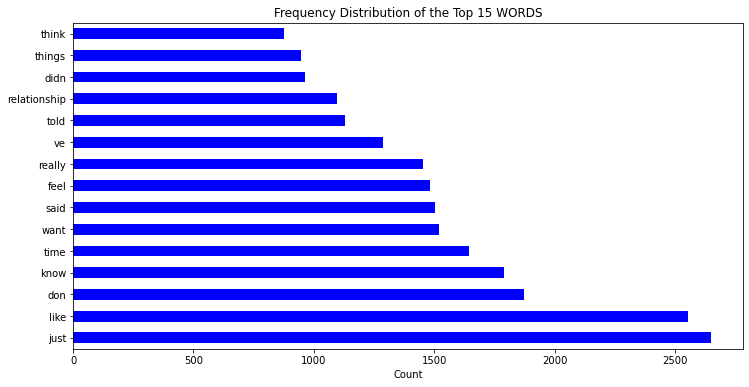

In [946]:
plt.title('Frequency Distribution of the Top 15 WORDS')
plt.xlabel('Count')
fifteen_words.plot(kind='barh', figsize=(12, 6), color='b');

In [988]:
last_fifteen_words = selftext_dataframe.sum(axis=0).sort_values(ascending=True)[:15]

In [989]:
last_fifteen_word
# These are 15 words used the fewest times. Could be due to punctuation.

übereinstimmt    1
evolve           1
evils            1
evie             1
evidently        1
eviction         1
evicted          1
everytinebi      1
niceguy          1
everythihng      1
ud               1
ufo              1
eversince        1
everlasting      1
stinging         1
dtype: int64

### MODELING

Following code inspired by NLP WalkThrough lesson
##### Create X and Y 

In [949]:
X = new_df['selftext']
y = new_df['subreddit']

###### Baseline Accuracy

In [950]:
y.value_counts(normalize=True)

# The model I create should predict better than this!

1    0.542513
0    0.457487
Name: subreddit, dtype: float64

###### Train/Test Split

In [951]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

### Logistic Regression

In [952]:
pipe = Pipeline([
    ('cv', CountVectorizer()),
    ('model', LogisticRegression())
])

# LOG: look for top coef of words

In [953]:
params = {
    'cv__stop_words': [None, 'english'],
    'cv__min_df': [1, 3, 5],
    'cv__max_df': [.6, .65, .7, .75]
}
# If a word is used more than 65% of the time, then we are getting rid of it.  
gs = GridSearchCV(pipe, param_grid=params)
gs.fit(X_train, y_train)
print(gs.best_score_) # <- cross val score of the best set of parameters
gs.best_params_

0.9596271866056533


{'cv__max_df': 0.65, 'cv__min_df': 5, 'cv__stop_words': None}

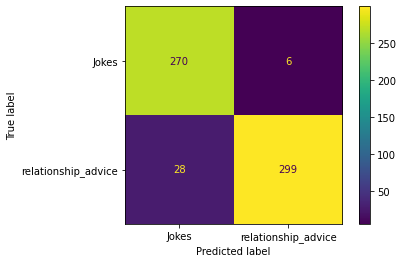

In [954]:
plot_confusion_matrix(gs, X_test, y_test, display_labels=['Jokes', 'relationship_advice']);

# 6 false positives 
# 28 false negatives 

In [955]:
preds = gs.predict(X_test)

In [956]:
# Code inspired by Aaron O'Neal
tn1, fp1, fn1, tp1 = confusion_matrix(y_test, preds).flatten()

In [957]:
# Specificity: How good was the model for predicting Jokes? True negative rate
tn1 / (tn1 + fp1)

0.9782608695652174

In [958]:
# Sensitivity: How good was the model for predicting relationship_advice? True positive rate, recall
tp1 / (tp1 + fn1)

0.9143730886850153

This model is better at predicting jokes, rather than relationship_advice. 

##### What's getting misclassified and why?!

In [960]:
((y_test != preds) & (preds == 0)).value_counts()

False    575
True      28
Name: subreddit, dtype: int64

In [961]:
# Find where this is true 
X_test[(y_test != preds) & (preds == 0)].head()
# This is where my model predicted jokes when it was actually relationship advice. 
# Jokes: 0, Relationship_advice: 1

2049                                                                                                                                                                                                                                                                                        so im in a relationship and i talked to other people on omegle is it cheating the guilt is really hurting me pls help guys.
2007                                                                                                                                                                                              So my gf took a photo down if us while she was in the shower and forgot to put it back. I found it on the toilet. I confronted her about it and she said she was looking at her tan on that side. Is this believable?
1768                                                                                                                                                                                    

The relationship posts seem to be longer in length and word count, while this one is on the shorter side. 

### Random Forest

In [962]:
pipe_rf = Pipeline([
    ('cv', CountVectorizer()),
    ('rf', RandomForestClassifier())
])

In [963]:
params_rf = {
    'cv__stop_words': [None, 'english'],
    'cv__min_df': [1, 3, 5],
    'cv__max_df': [.6, .65, .7, .75]
}
# If a word is used more than .60% of the time, then we are getting rid of it.  
# Model prefers english stop words!

In [964]:
gs_rf = GridSearchCV(pipe_rf, param_grid=params_rf)
gs_rf.fit(X_train, y_train)
print(gs_rf.best_score_) # <- cross val score of the best set of parameters
gs_rf.best_params_

0.9352917769853537


{'cv__max_df': 0.6, 'cv__min_df': 3, 'cv__stop_words': 'english'}

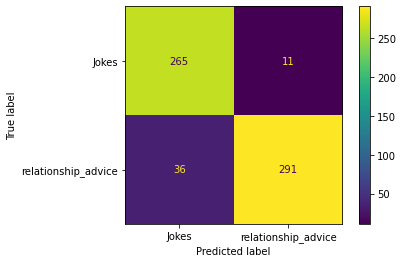

In [965]:
plot_confusion_matrix(gs_rf, X_test, y_test, display_labels=['Jokes', 'relationship_advice']);

In [966]:
preds_rf = gs_rf.predict(X_test)

In [967]:
tn2, fp2, fn2, tp2 = confusion_matrix(y_test, preds_rf).flatten()

In [968]:
# Specificity: How good was the model for predicting Jokes? 
tn2 / (tn2 + fp2)

0.9601449275362319

In [969]:
# Sensitivity: How good was the model for predicting relationship_advice? 
tp2 / (tp2 + fn2)

0.8899082568807339

This model is also better at predicting jokes, rather than relationship_advice. 

###### What's getting misclassified and why?!

In [971]:
((y_test != preds_rf) & (preds_rf == 0)).value_counts()

False    567
True      36
Name: subreddit, dtype: int64

In [972]:
X_test[(y_test != preds_rf) & (preds_rf == 0)].head()

1413    My girlfriend has a bestfreind \nWho is basically a very confident guy and he has almost every thing in him which she likes \nAnd I am not the same and i have a very low self esteem \nAnd people take me for granted and no one gives a flying fuck about me \nI am not even physically attractive\nSo i am jealous of her freind and i degrade and compare myself to him everytime\nWhat should I do to m...
2007                                                                                                                                                                                              So my gf took a photo down if us while she was in the shower and forgot to put it back. I found it on the toilet. I confronted her about it and she said she was looking at her tan on that side. Is this believable?
1250                                                                                         I’m a bisexual who’s been one for over 10 years now. I’ve met another woman who used the cl

Profanity or words like "sex," "jokes," "toilet," "poop," and "fart," probably come up very often when telling jokes and speaking about relationships. 
ie; 1768: Men how like to make sexual jokes, always looking at women their buts or boops and have perverted idea's. Do you find them attractive?

Word count and length of posts are very telling of which subreddit a post belongs. The word count for posts on the Jokes subreddit, on average, are 8 times shorted than those of relationship advice posts. All of the misclassified posts above were predicted as jokes when they were in fact posts from the relationship advice subreddit. This is probably because these posts not only contain the factors as mentioned above, but also because they are shorter in length much like the joke posts. 